In [2]:
!pip install jsonlines
!pip install sparqlwrapper
!pip install tqdm

import json

from SPARQLWrapper import SPARQLWrapper, JSON
import jsonlines
import pandas as pd
from tqdm import tqdm

In [ ]:
kelm_path = "../kelm/kelm_generated_corpus.jsonl"
kelm_entities_path = "../kelm/entities.jsonl"

In [ ]:
with open(kelm_path) as json_file:
    json_list = list(json_file)
print(json_list[0])

{"triples": [["Valentin Lavigne", "member of sports team", "FC Lorient"], ["Valentin Lavigne", "FC Lorient", "start time", "01 January 2014"], ["Valentin Lavigne", "FC Lorient", "end time", "01 January 2016"]], "serialized_triples": "Valentin Lavigne member of sports team FC Lorient, FC Lorient end time 01 January 2016, FC Lorient start time 01 January 2014.", "gen_sentence": "Valentin Lavigne played for FC Lorient between 2014 and 2016."}



Todo:

- [] get all person examples about person entities and give gender distribution
- [] get all location examples and determine global distribution

# Analyze gender distribution

In [11]:
user_agent = 'AngelieKraftUHH (angelie.kraft@uni-hamburg.de)'
sparql = SPARQLWrapper("https://query.wikidata.org/sparql", agent=user_agent)
entity_path = "../../wikidata_humans/wikidata_all_human_entities.jsonl"

ids = []
genders = []
dobs = []
pobs = []
with open(entity_path) as json_file:
    json_list = list(json_file)

for entry in json_list:
      entry = json.loads(entry)
      ids += [entry["entity_id"]]
      genders += [entry["gender"]]
      dobs += [entry["DOB"]]
      pobs += [entry["POB"]]


In [12]:
gender_map = {}
for g in list(set(genders)):
    sparql.setQuery(f"""
    SELECT  *
    WHERE 
    {{
        wd:{g} rdfs:label ?label .
        FILTER (langMatches( lang(?label), "EN" ) )
    }}
    """)
    sparql.setReturnFormat(JSON)
    query_result = sparql.query().convert()

    try:
        gender_map[g] = query_result["results"]["bindings"][0]["label"]["value"]
    except:
        pass
  

In [14]:
gender_map[""] = "unknown"

In [15]:
from collections import Counter

genders_decoded = [gender_map[g] for g in genders]
gender_frequencies = dict(Counter(genders_decoded))
gender_frequencies

{'male': 6140593,
 'female': 1988367,
 'trans woman': 1387,
 'unknown': 2080255,
 'non-binary': 588,
 'trans man': 310,
 'intersex': 76,
 'faʻafafine': 5,
 'hijra': 3,
 'eunuch': 142,
 'agender': 19,
 'androgyne': 3,
 'genderqueer': 39,
 'undisclosed gender': 1,
 'transgender': 24,
 'genderfluid': 44,
 'travesti': 4,
 'cisgender female': 21,
 'two-spirit': 16,
 'transmasculine': 8,
 'bigender': 6,
 'assigned male at birth': 1,
 'neutrois': 4,
 'indefinite': 1,
 'takatāpui': 3,
 'female organism': 5,
 'transfeminine': 6,
 'Jamaica': 1,
 'neutral sex': 5,
 'muxe': 2,
 'intersex person': 3,
 'pangender': 1,
 'queer': 1,
 'Alien': 1,
 'māhū': 1,
 'X-gender': 1,
 'demiboy': 1,
 "'akava'ine": 1,
 'vakasalewalewa': 1,
 'third gender': 1}

In [16]:
grouped_frequencies = {}
grouped_frequencies["female"] = 0
grouped_frequencies["male"] = 0
grouped_frequencies["unknown"] = 0
grouped_frequencies["non-binary/transgender/other"] = 0
for k,v in gender_frequencies.items():
    if k in ["female", "cisgender female", "trans woman"]:
        grouped_frequencies["female"] += v
    elif k in ["male", "trans man"]:
        grouped_frequencies["male"] += v
    elif k in ["unknown", "undisclosed gender"]:
        grouped_frequencies["unknown"] += v
    else:
        grouped_frequencies["non-binary/transgender/other"] += v

In [24]:
grouped_frequencies = {k: v for k, v in sorted(grouped_frequencies.items(), key=lambda item: item[1], reverse=True)}

In [25]:
grouped_frequencies

{'male': 6140903,
 'unknown': 2080256,
 'female': 1989775,
 'non-binary/transgender/other': 1017}

In [18]:

!pip install matplotlib seaborn
import matplotlib.pyplot as plt
import seaborn as sns

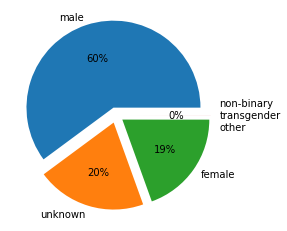

In [29]:
labels = ["\n".join(i.split("/")) for i in grouped_frequencies.keys()]
plt.pie(grouped_frequencies.values(), labels=labels,  explode=[0.09]*4, autopct='%.0f%%')
plt.savefig('wikidata_gender_distr_Oct2022.png', dpi=300)
plt.show()

In [31]:
save_dict = {}
save_dict["map"] = gender_map
save_dict["frequencies"] = gender_frequencies
save_dict["grouped_frequencies"] = grouped_frequencies

with open("wikidata_genders.json", "w") as f:
    json.dump(save_dict, f)